<h1>Compare Real and Complex Source Separation Performance</h1>
<h2>Michael A. Casey - Bregman Labs - Dartmouth College</h2>

In [5]:
from pylab import *
from bregman.suite import *
import cseparate as cs
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
help(cs.cseparate) # COMPLEX MATRIX FACTORIZATION

Help on function cseparate in module cseparate:

cseparate(x, M=None, N=4096, H=1024, W=4096, max_iter=200, pre_emphasis=False)
    complex-valued frequency domain separation by independent components
    using relative phase representation
    
    inputs:
      x - the audio signal to separate (1 row)
      M - the number of sources to extract
    options:
      N - fft length in samples [4096]
      H - hop size in samples   [1024]
      W - window length in samples (fft padded with N-W zeros) [4096]
      max_iter - maximum JADE ICA iterations [200]
      pre_emphasis - apply an exponential spectral pre-emphasis filter [False]
    output:
      xhat - the separated signals (M rows)
      xhat_all - the M separated signals mixed (1 row)
    
    Copyright (C) 2014 Michael A. Casey, Bregman Media Labs, 
    Dartmouth College All Rights Reserved



In [7]:
help(plca.PLCA.analyze) # REAL MATRIX FACTORIZATION

Help on method analyze in module bregman.plca:

analyze(cls, V, rank, niter=100, convergence_thresh=1e-09, printiter=50, plotiter=None, plotfilename=None, initW=None, initZ=None, initH=None, updateW=True, updateZ=True, updateH=True, **kwargs) method of __builtin__.type instance
    Iteratively performs the PLCA decomposition using the EM algorithm
    
    Parameters
    ----------
    V : array, shape (`F`, `T`)
        Matrix to analyze.
    niter : int
        Number of iterations to perform.  Defaults to 100.
    convergence_thresh : float
    updateW, updateZ, updateH : boolean
        If False keeps the corresponding parameter fixed.
        Defaults to True.
    initW, initZ, initH : array
        Initial settings for `W`, `Z`, and `H`.  Unused by default.
    printiter : int
        Prints current log probability once every `printiter`
        iterations.  Defaults to 50.
    plotiter : int or None
        If not None, the current decomposition is plotted once
        every `pl

In [8]:
x,sr,fmt = wavread('amen.wav')

In [12]:
def rc_err(x, reduce_mse=True, normalize_recon=True, nfft=4096, ncomps=range(2,13), pre_emphasis=True):
    """
    Compare real and complex spectrum factorization and reconstruction with Mean Square Error.
    inputs:
        x - the one-dimensional audio signal to factorize via its spectrum
        reduce_mse - whether to take the MSE (True) or the SE (False) for each evaluation [True]
        normalize_recon - normalize reconstruction spectra prior to MSE/SE calculation [True]
        nfft - fft size [4096]
        ncomps - list of number of components to test [range(2,13)]
        pre_emphasis - whether to apply high-frequency pre-emphasis filter to spectrum [True]
    outputs:
        real_err - list of Real MSE (default) or SE spectra (reduce_mse=False)
        cmplx_err -list of Complex MSE (default) or SE spectra (reduce_mse=False)
    """
    x = x-x.mean() # center the original signal
    x = x/abs(x).max() # normalize the original signal
    real_err, cmplx_err = [],[] # result lists
    N=nfft;W=N/2;H=N/4 # FFT parameters
    # ORIGINAL SPECTRUM (normalized)
    Xo = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
    oX = Xo.X # grab the real magnitude spectrum
    if normalize_recon:
        oX = feature_scale(oX, normalize=1) # ORIGINAL |STFT| normalized
    for K in ncomps: # n_components    
        # REAL RECONSTRUCTION (normalized)
        Xr = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
        Xr.separate(cls=PLCA, n=K) # real separation (PLCA)
        # REAL ERROR
        rX = array(Xr.X_hat)[:,:,:oX.shape[1]].sum(0) # Real spectral components summed
        if normalize_recon:
            rX = feature_scale(rX, normalize=1) # Normalize
        sqerr_real = (oX - rX)**2
        # COMPLEX RECONSTRUCTION (normalized)
        xci, xc = cs.cseparate(x,K,N,H,W,pre_emphasis=pre_emphasis) # complex separation (CJADE)
        xc = xc-xc.mean() # center
        xc = xc/abs(xc).max() # normalize
        Xc = LinearFrequencySpectrum(xc, nfft=N, wfft=W, nhop=H)
        # COMPLEX ERROR
        cX = Xc.X[:,:oX.shape[1]] # Complex spectral components already summed by cseparate
        if normalize_recon:
            cX = feature_scale(cX, normalize=1)
        sqerr_cmplx = (oX - cX)**2
        # Append Results
        real_err.append(sqerr_real)
        cmplx_err.append(sqerr_cmplx)
    if reduce_mse:
        real_err = [r.mean() for r in real_err]
        cmplx_err = [c.mean() for c in cmplx_err]            
    return real_err, cmplx_err

In [10]:
# Run the experiment
real_err,cmplx_err = rc_err(x) 

/home/mkc/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


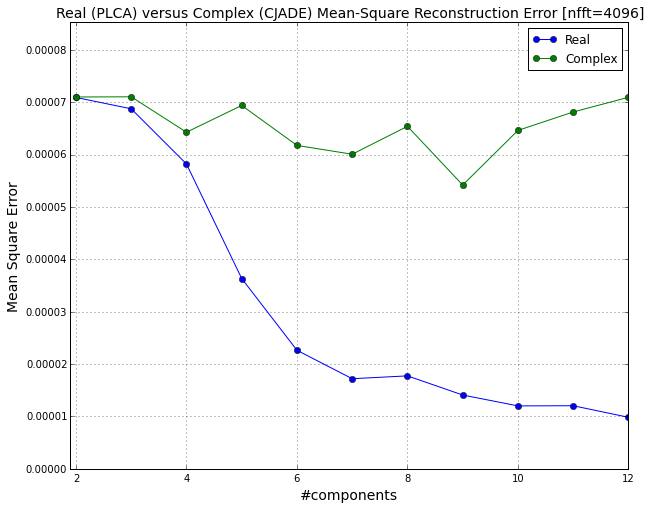

In [11]:
# Plot the results of the experiment
plot(range(2,13),real_err,'-o')
plot(range(2,13),cmplx_err,'-o')
title('Real (PLCA) versus Complex (CJADE) Mean-Square Reconstruction Error [nfft=4096]', fontsize=14)
ylabel('Mean Square Error', fontsize=14)
xlabel('#components', fontsize=14)
legend(['Real','Complex'])
axis(xmin=1.9, ymax=max(max(real_err),max(cmplx_err))*1.2) # Autoscale y axis
grid()

In [13]:
# Do the same again, without pre-emphasis
real_err,cmplx_err = rc_err(x, pre_emphasis=False)

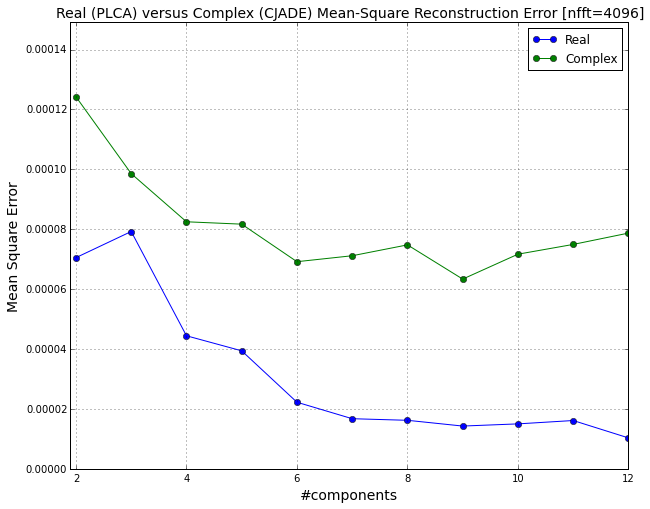

In [14]:
# Plot the results of the experiment
plot(range(2,13),real_err,'-o')
plot(range(2,13),cmplx_err,'-o')
title('Real (PLCA) versus Complex (CJADE) Mean-Square Reconstruction Error [nfft=4096]', fontsize=14)
ylabel('Mean Square Error', fontsize=14)
xlabel('#components', fontsize=14)
legend(['Real','Complex'])
axis(xmin=1.9, ymax=max(max(real_err),max(cmplx_err))*1.2) # Autoscale y axis
grid()

## Plot real and complex reconstructions 

Reconstruct spectrum from real and complex components. Visualize

In [17]:
x = x - x.mean() # center the original signal
x = x / abs(x).max() # normalize the original signal
real_ncomps = argmin(real_err)+2 # The component range was (2,13)
cmplx_ncomps = argmin(cmplx_err)+2 
N=4096;W=N/2;H=N/4 # FFT parameters
Xo = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
oX = Xo.X # grab the real magnitude spectrum
oX = feature_scale(oX, normalize=1) # ORIGINAL |STFT| normalized
# REAL RECONSTRUCTION (normalized)
Xr = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
Xr.separate(cls=PLCA, n=real_ncomps) # real separation (PLCA)
# REAL ERROR
rX = array(Xr.X_hat)[:,:,:oX.shape[1]].sum(0) # Real spectral components summed
rX = feature_scale(rX, normalize=1) # Normalize
sqerr_real = (oX - rX)**2
# COMPLEX RECONSTRUCTION (normalized)
xci, xc = cs.cseparate(x,cmplx_ncomps,N,H,W,pre_emphasis=True) # complex separation (CJADE)
xc = xc-xc.mean() # center
xc = xc/abs(xc).max() # normalize
Xc = LinearFrequencySpectrum(xc, nfft=N, wfft=W, nhop=H)
# COMPLEX ERROR
cX = Xc.X[:,:oX.shape[1]] # Complex spectral components already summed by cseparate
cX = feature_scale(cX, normalize=1)
sqerr_cmplx = (oX - cX)**2


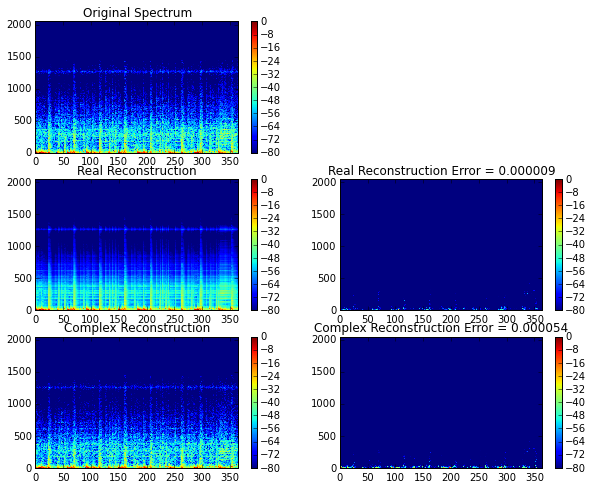

In [19]:
subplot(321)
feature_plot(oX,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Original Spectrum')
subplot(323)
feature_plot(rX,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Real Reconstruction')
subplot(324)
feature_plot(sqerr_real,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Real Reconstruction Error = {:3f}'.format(sqerr_real.mean()))
subplot(325)
feature_plot(cX,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Complex Reconstruction')
subplot(326)
feature_plot(sqerr_cmplx,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Complex Reconstruction Error = {:3f}'.format(sqerr_cmplx.mean()))

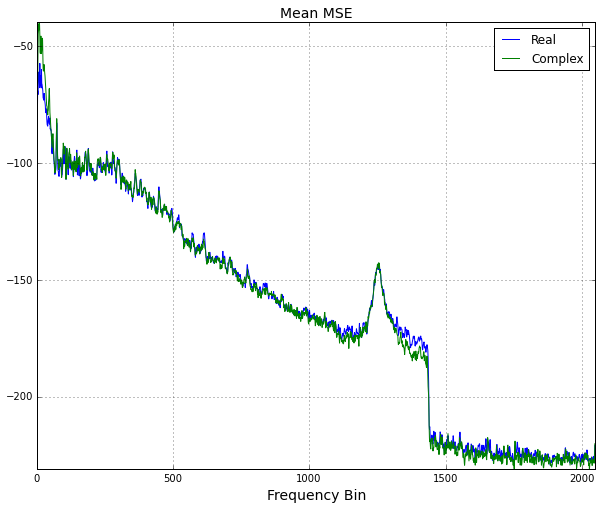

In [40]:
plot(20*log10(sqerr_real.mean(1)))
plot(20*log10(sqerr_cmplx.mean(1)))
title('Mean MSE', fontsize=14)
xlabel('Frequency Bin', fontsize=14)
legend(['Real','Complex'])
axis('tight')
grid()

## Audio Reconstruction: Real (Random Phases) and Complex (Reconstructed Phases)

In [33]:
# Real reconstruction
x_hat = Xr.inverse(rX, Phi_hat=(rand(*Xr.STFT.shape)-0.5)*np.pi)
# Play the real reconstruction
play(balance_signal(x_hat))

Period size is 64 , Buffer size is 22050


In [34]:
# Play the complex reconstruction
play(xc)

Period size is 64 , Buffer size is 22050
